# Plotting MAP predictions.

This notebook produces figure 3 from Donald-McCann, Koyama, Beutler (in-prep).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matryoshka.emulator as MatEmu
from scipy.interpolate import interp1d
import matplotlib.colors as mcolors
import matplotlib.lines as mlines

In [2]:
path_to_repo = "/Users/jamie/Desktop/GitHubProjects/matryoshka_II_paper/"

In [3]:
P0_true_list = []
P2_true_list = []
cov_list = []
for zi in [0.38, 0.51, 0.61]:
    P0_true_list.append(np.load(path_to_repo+"data/P18/z{z}/poles/P0_P18--z-{z}_optiresum-False.npy".format(z=zi))[1])
    P2_true_list.append(np.load(path_to_repo+"data/P18/z{z}/poles/P2_P18--z-{z}_optiresum-False.npy".format(z=zi))[1])
    cov_list.append(np.load(path_to_repo+"data/P18/z{z}/covs/cov_P18--z-{z}_Vs-3700.npy".format(z=zi)))
klin = np.load(path_to_repo+"data/P18/z{z}/poles/P0_P18--z-{z}_optiresum-False.npy".format(z=zi))[0]

In [4]:
cosmo_true = np.array([0.11933, 0.02242, 0.6766, 3.047, 0.9665])
ng = 3e-4
fb_true = cosmo_true[1]/(cosmo_true[0]+cosmo_true[1])
fixed_params = np.array([cosmo_true[-1], 0., 0., 0.])

In [5]:
def fix_params(theta, fix_val, fb):
    
    # Define indicies of parameters that vary.
    var_id = np.array([0,2,3,5,6,7,9,10,12,14])
    
    # Define indicies of fixed params.
    fix_id = np.array([4,8,11,13])
    
    fix_theta = np.zeros((theta.shape[0], 15))
    fix_theta[:,var_id] = theta
    fix_theta[:,fix_id] = np.vstack(theta.shape[0]*[fix_val])
    
    # Comput w_b from baryon fraction and w_c
    fix_theta[:,1] = -fb*theta[:,0]/(fb-1)
    
    return fix_theta

In [6]:
def power_pred(theta, kobs, ng, fixed_vals, fb):
    theta = theta.reshape(1,-1)
    theta = fix_params(theta, fixed_vals, fb)
    
    # Oc, Ob, h, As, ns
    cosmo = theta[:,:5]
    # b1, c2, b3, c4, cct, cr1, cr2
    bias = theta[:,5:12]
    # ce1, cmono, cquad
    stoch = theta[:,12:]
    
    
    c2 = np.copy(bias[:,1])
    c4 = np.copy(bias[:,3])
    
    bias[:,1] = (c2+c4)/np.sqrt(2)
    bias[:,3] = (c2-c4)/np.sqrt(2)
            
    P0_pred = P0_emu.emu_predict(cosmo, bias, stochastic=stoch, ng=ng)
    P2_pred = P2_emu.emu_predict(cosmo, bias, stochastic=stoch, ng=ng)
    
    return interp1d(MatEmu.kbird[:39], P0_pred)(kobs), interp1d(MatEmu.kbird[:39], P2_pred)(kobs)

In [7]:
P0_pred_list = []
P2_pred_list = []
for zi in [0.38, 0.51, 0.61]:
    MAP = np.load(path_to_repo+"results/MAP--EFTEMU_z-{z}_V-3700_kmin-def_kmax-def_0.npy".format(z=zi))
    P0_emu = MatEmu.EFT(multipole=0, redshift=zi)
    P2_emu = MatEmu.EFT(multipole=2, redshift=zi)
    P0_pred, P2_pred = power_pred(MAP, klin, ng, fixed_params, fb_true)
    P0_pred_list.append(P0_pred[0])
    P2_pred_list.append(P2_pred[0])

2022-02-07 11:39:45.466414: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


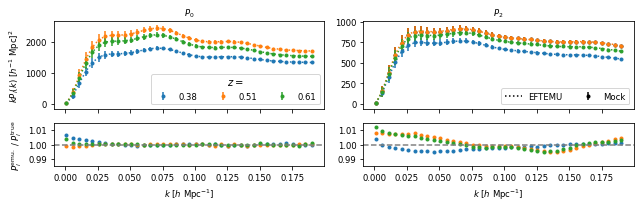

In [8]:
fig, ax = plt.subplots(2,2, sharex=True, figsize=(9,3), gridspec_kw={'height_ratios': [2, 1]})
colours = list(mcolors.TABLEAU_COLORS.keys())
label_font = 8.5
legend_font = 8.5
for axi in ax.flatten():
    axi.tick_params(axis='both', which='major', labelsize=8.5)
for i, zi in enumerate([0.38, 0.51, 0.61]):
    
    # Top panel
    ax[0,0].errorbar(klin, klin*P0_true_list[i],
                     yerr=np.sqrt(cov_list[i].diagonal()[:len(klin)])*klin*5,
                     linestyle='none', marker='.', label=str(zi), color=colours[i])
    ax[0,1].errorbar(klin, klin*P2_true_list[i],
                     yerr=np.sqrt(cov_list[i].diagonal()[len(klin):])*klin,
                     linestyle='none', marker='.', color=colours[i])
    ax[0,0].plot(klin, klin*P0_pred_list[i], linestyle=':', color=colours[i])
    ax[0,1].plot(klin, klin*P2_pred_list[i], linestyle=':', color=colours[i])

    # Bottom panel
    ax[1,0].plot(klin, P0_pred_list[i]/P0_true_list[i], linestyle='none', marker='.', color=colours[i])
    ax[1,1].plot(klin, P2_pred_list[i]/P2_true_list[i], linestyle='none', marker='.', color=colours[i])  

for i in range(2):
    ax[1,i].axhline(1., color='grey', linestyle='--')
    ax[1,i].set_ylim(0.985, 1.015)
    
# Text
ax[0,0].set_title(r"$P_0$", fontsize=label_font)
ax[0,1].set_title(r"$P_2$", fontsize=label_font)
ax[1,1].set_xlabel(r'$k \ [h \ \mathrm{Mpc}^{-1}]$',fontsize=label_font)
ax[1,0].set_xlabel(r'$k \ [h \ \mathrm{Mpc}^{-1}]$',fontsize=label_font)
ax[0,0].set_ylabel(r'$kP_l(k) \ [h^{-1} \ \mathrm{Mpc}]^2$',fontsize=label_font)
ax[1,0].set_ylabel(r'$P_l^\mathrm{emu.} \ / \ P_l^\mathrm{true}$',fontsize=label_font)


dotted = mlines.Line2D([], [], color='k', marker=None, linestyle=':', label='EFTEMU')
err_bar = ax[0,1].errorbar(klin, klin*P2_true_list[i], yerr=np.sqrt(cov_list[i].diagonal()[len(klin):])*klin,
                     linestyle='none', marker='.', color='k', zorder=-1, label='Mock')

ax[0,0].legend(ncol=3, fontsize=legend_font, title=r"$z=$")
ax[0,1].legend(ncol=2, handles=[dotted, err_bar], fontsize=legend_font)
plt.tight_layout()

plt.savefig(path_to_repo+"plots/map_predictions_redshift.png", dpi=300, facecolor='white')